In [190]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn import tree, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np

In [142]:
#connect to sqlite database
cnx = sqlite3.connect('./188-million-us-wildfires/FPA_FOD_20170508.sqlite')

In [143]:
cursor = cnx.cursor()
cursor.execute('SELECT name FROM SQLITE_MASTER WHERE TYPE="table"')
print(cursor.fetchall())

[('spatial_ref_sys',), ('spatialite_history',), ('sqlite_sequence',), ('geometry_columns',), ('spatial_ref_sys_aux',), ('views_geometry_columns',), ('virts_geometry_columns',), ('geometry_columns_statistics',), ('views_geometry_columns_statistics',), ('virts_geometry_columns_statistics',), ('geometry_columns_field_infos',), ('views_geometry_columns_field_infos',), ('virts_geometry_columns_field_infos',), ('geometry_columns_time',), ('geometry_columns_auth',), ('views_geometry_columns_auth',), ('virts_geometry_columns_auth',), ('sql_statements_log',), ('SpatialIndex',), ('ElementaryGeometries',), ('KNN',), ('Fires',), ('idx_Fires_Shape',), ('idx_Fires_Shape_node',), ('idx_Fires_Shape_rowid',), ('idx_Fires_Shape_parent',), ('NWCG_UnitIDActive_20170109',)]


In [144]:
#select the Fires table
fires_table = pd.read_sql_query("SELECT * FROM Fires", cnx)
fires_table.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape'],
      dtype='object')

In [145]:
fires_table.shape

(1880465, 39)

In [6]:
#selecting some potential columns for analysis
df = pd.read_sql_query("SELECT FIRE_YEAR, DISCOVERY_DATE, DISCOVERY_DOY, STAT_CAUSE_DESCR, FIRE_SIZE, FIRE_SIZE_CLASS, LATITUDE, LONGITUDE, STATE, CONT_DATE FROM Fires", cnx)
print(df.head(10))

   FIRE_YEAR  DISCOVERY_DATE  DISCOVERY_DOY STAT_CAUSE_DESCR  FIRE_SIZE  \
0       2005       2453403.5             33    Miscellaneous       0.10   
1       2004       2453137.5            133        Lightning       0.25   
2       2004       2453156.5            152   Debris Burning       0.10   
3       2004       2453184.5            180        Lightning       0.10   
4       2004       2453184.5            180        Lightning       0.10   
5       2004       2453186.5            182        Lightning       0.10   
6       2004       2453187.5            183        Lightning       0.10   
7       2005       2453437.5             67   Debris Burning       0.80   
8       2005       2453444.5             74   Debris Burning       1.00   
9       2004       2453187.5            183        Lightning       0.10   

  FIRE_SIZE_CLASS   LATITUDE   LONGITUDE STATE  CONT_DATE  
0               A  40.036944 -121.005833    CA  2453403.5  
1               A  38.933056 -120.404444    CA  245313

In [7]:
df.fillna(0, inplace=True)

In [8]:
df.isnull().any()

FIRE_YEAR           False
DISCOVERY_DATE      False
DISCOVERY_DOY       False
STAT_CAUSE_DESCR    False
FIRE_SIZE           False
FIRE_SIZE_CLASS     False
LATITUDE            False
LONGITUDE           False
STATE               False
CONT_DATE           False
dtype: bool

In [9]:
#change the discovery_date format to readable date format
df['DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
print(df.head(10))

   FIRE_YEAR  DISCOVERY_DATE  DISCOVERY_DOY STAT_CAUSE_DESCR  FIRE_SIZE  \
0       2005       2453403.5             33    Miscellaneous       0.10   
1       2004       2453137.5            133        Lightning       0.25   
2       2004       2453156.5            152   Debris Burning       0.10   
3       2004       2453184.5            180        Lightning       0.10   
4       2004       2453184.5            180        Lightning       0.10   
5       2004       2453186.5            182        Lightning       0.10   
6       2004       2453187.5            183        Lightning       0.10   
7       2005       2453437.5             67   Debris Burning       0.80   
8       2005       2453444.5             74   Debris Burning       1.00   
9       2004       2453187.5            183        Lightning       0.10   

  FIRE_SIZE_CLASS   LATITUDE   LONGITUDE STATE  CONT_DATE       DATE  
0               A  40.036944 -121.005833    CA  2453403.5 2005-02-02  
1               A  38.933056 -12

In [10]:
df['MONTH'] = pd.DatetimeIndex(df['DATE']).month
print(df.head())

   FIRE_YEAR  DISCOVERY_DATE  DISCOVERY_DOY STAT_CAUSE_DESCR  FIRE_SIZE  \
0       2005       2453403.5             33    Miscellaneous       0.10   
1       2004       2453137.5            133        Lightning       0.25   
2       2004       2453156.5            152   Debris Burning       0.10   
3       2004       2453184.5            180        Lightning       0.10   
4       2004       2453184.5            180        Lightning       0.10   

  FIRE_SIZE_CLASS   LATITUDE   LONGITUDE STATE  CONT_DATE       DATE  MONTH  
0               A  40.036944 -121.005833    CA  2453403.5 2005-02-02      2  
1               A  38.933056 -120.404444    CA  2453137.5 2004-05-12      5  
2               A  38.984167 -120.735556    CA  2453156.5 2004-05-31      5  
3               A  38.559167 -119.913333    CA  2453189.5 2004-06-28      6  
4               A  38.559167 -119.933056    CA  2453189.5 2004-06-28      6  


In [11]:
fire_year = df.groupby('FIRE_YEAR').size()
fire_year[:5]

FIRE_YEAR
1992    67975
1993    61989
1994    75955
1995    71472
1996    75574
dtype: int64

In [12]:
type(fire_year)

pandas.core.series.Series

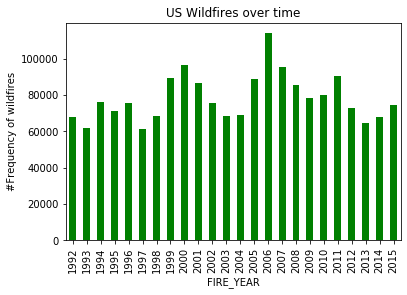

In [146]:
fire_year.plot(kind='bar', color='green')
plt.ylabel('#Frequency of wildfires')
plt.title('US Wildfires over time')
plt.show()

In [14]:
#Number of Wildfires by Fire_Size
fire_size = df.groupby('FIRE_SIZE_CLASS').size()
fire_size[:5]

FIRE_SIZE_CLASS
A    666919
B    939376
C    220077
D     28427
E     14107
dtype: int64

In [15]:
fire_size.index

Index(['A', 'B', 'C', 'D', 'E', 'F', 'G'], dtype='object', name='FIRE_SIZE_CLASS')

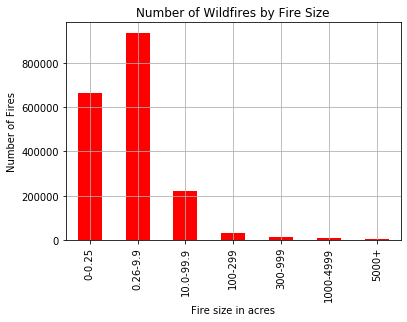

In [16]:
#The ranges of fire size are set as given in the dataset documentation
fire_size_ranges = ['0-0.25', '0.26-9.9', '10.0-99.9', '100-299', '300-999', '1000-4999', '5000+']
fire_size.plot(kind='bar', color='red')
plt.xticks(np.arange(len(fire_size.index)), fire_size_ranges)
plt.xlabel('Fire size in acres')
plt.ylabel('Number of Fires')
plt.title('Number of Wildfires by Fire Size')
plt.grid(True)
plt.show()

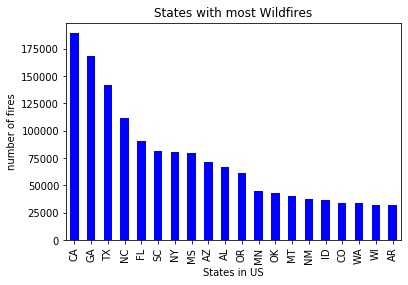

In [172]:
df['STATE'].value_counts().head(n=20).plot(kind='bar', color='blue')
plt.xlabel("States in US")
plt.ylabel("number of fires")
plt.title("States with most Wildfires")
plt.show()

Text(0.5, 1.0, 'Causes of Wildfires')

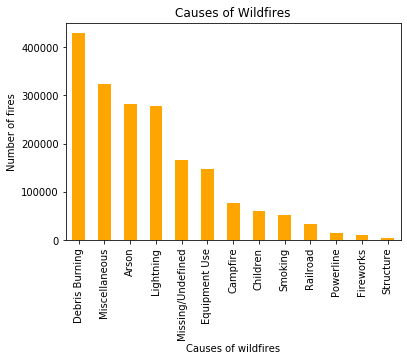

In [151]:
df['STAT_CAUSE_DESCR'].value_counts().plot(kind='bar', color='orange')
plt.xlabel("Causes of wildfires")
plt.ylabel("Number of fires")
plt.title("Causes of Wildfires")

In [18]:
#calculate burn time for each reason
df['BURN_TIME'] = df['CONT_DATE'] - df['DISCOVERY_DATE']

In [90]:
df['DAY_OF_WEEK'] = df['DATE'].dt.weekday_name
df['DAY_OF_WEEK'] = le.fit_transform(df['DAY_OF_WEEK'])

In [19]:
target = ['STAT_CAUSE_DESCR']

In [20]:
features = ['FIRE_SIZE', 'DISCOVERY_DOY', 'LONGITUDE', 'LATITUDE', 'BURN_TIME', 'MONTH']

In [21]:
X = df[features]

In [22]:
y = df[target]

In [23]:
X.iloc[3]

FIRE_SIZE          0.100000
DISCOVERY_DOY    180.000000
LONGITUDE       -119.913333
LATITUDE          38.559167
BURN_TIME          5.000000
MONTH              6.000000
Name: 3, dtype: float64

In [24]:
y

,STAT_CAUSE_DESCR
0,Miscellaneous
1,Lightning
2,Debris Burning
3,Lightning
4,Lightning
...,...
1880460,Missing/Undefined
1880461,Miscellaneous
1880462,Missing/Undefined
1880463,Missing/Undefined


#### 1. Decision Tree Classifier

In [25]:
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.33)

In [25]:
cause_classifier = DecisionTreeClassifier(max_leaf_nodes=20, random_state=0)
cause_classifier.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=20,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [26]:
predictions = cause_classifier.predict(X_test)

In [27]:
predictions[:10]

array(['Arson', 'Lightning', 'Miscellaneous', 'Debris Burning',
       'Debris Burning', 'Arson', 'Arson', 'Lightning', 'Miscellaneous',
       'Lightning'], dtype=object)

In [28]:
y_test['STAT_CAUSE_DESCR'][:10]

540725              Arson
91365           Lightning
268337           Children
1741818     Equipment Use
663992     Debris Burning
1758892    Debris Burning
1242232             Arson
127066          Lightning
1289816    Debris Burning
1181554          Campfire
Name: STAT_CAUSE_DESCR, dtype: object

In [29]:
accuracy_score(y_true=y_test, y_pred=predictions)

0.4054522249473857

#### 2. Random Forest Classifier

In [30]:
random_classifier = RandomForestClassifier(n_estimators=50)

In [31]:
random_classifier.fit(X_train, y_train)

C:\Tech\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [32]:
pred = random_classifier.predict(X_test)

In [33]:
accuracy_score(y_true=y_test, y_pred=pred)

0.556678387376441

Try with some attributes for a particular state and a cause

In [153]:
#pick a state and cause to predict the features of wildfire
df_GA = df[df['STATE'] == 'GA']

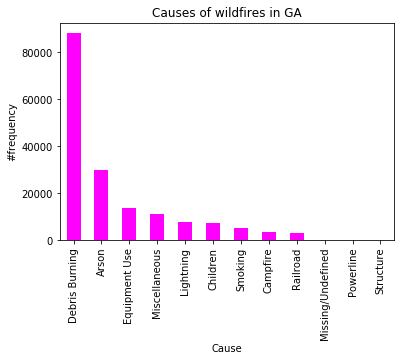

In [154]:
df_GA['STAT_CAUSE_DESCR'].value_counts().plot(kind='bar', color='magenta', title = 'Causes of wildfires in GA')
plt.xlabel("Cause")
plt.ylabel("#frequency")
plt.show()

In [158]:
df_GA['DEBRIS_BURNING'] = (df_GA['STAT_CAUSE_DESCR'] == 'Debris Burning')*1
print(df_GA.head())

      FIRE_YEAR  DISCOVERY_DATE  DISCOVERY_DOY STAT_CAUSE_DESCR  FIRE_SIZE  \
4447       2005       2453678.5            308            Arson        0.1   
4451       2005       2453678.5            308            Arson        0.5   
4455       2005       2453686.5            316   Debris Burning        4.0   
4463       2005       2453677.5            307   Debris Burning        3.0   
4777       2005       2453441.5             71   Debris Burning        2.3   

     FIRE_SIZE_CLASS   LATITUDE  LONGITUDE STATE  CONT_DATE       DATE  MONTH  \
4447               A  34.895556 -84.675833    GA  2453678.5 2005-11-04     11   
4451               B  34.894444 -84.666944    GA  2453678.5 2005-11-04     11   
4455               B  34.597222 -85.020833    GA  2453686.5 2005-11-12     11   
4463               B  34.745556 -85.044722    GA  2453677.5 2005-11-03     11   
4777               B  34.871944 -83.934167    GA  2453441.5 2005-03-12      3   

      BURN_TIME  DAY_OF_WEEK  DEBRIS_BURNING

C:\Tech\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [159]:
le = preprocessing.LabelEncoder()
df_GA['DAY_OF_WEEK'] = le.fit_transform(df_GA['DAY_OF_WEEK'])

C:\Tech\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [160]:
df_GA = df_GA.drop('DATE',axis=1)
df_GA = df_GA.drop('STATE',axis=1)
df_GA = df_GA.drop('STAT_CAUSE_DESCR',axis=1)
df_GA = df_GA.drop('FIRE_SIZE',axis=1)
df_GA = df_GA.dropna()

In [161]:
df_GA = df_GA.drop('FIRE_SIZE_CLASS', axis=1)

In [162]:
df_GA = df_GA.drop('FIRE_YEAR', axis=1)

In [163]:
debris_features = ['FIRE_SIZE', 'LATITUDE', 'LONGITUDE', 'MONTH', 'DISCOVERY_DATE', 'DAY_OF_WEEK']

In [164]:
target = ['DEBRIS_BURNING']

In [165]:
X1 = df_GA.drop(['DEBRIS_BURNING'], axis=1).values

In [166]:
X1[:5]

array([[ 2.45367850e+06,  3.08000000e+02,  3.48955556e+01,
        -8.46758333e+01,  2.45367850e+06,  1.10000000e+01,
         0.00000000e+00,  0.00000000e+00],
       [ 2.45367850e+06,  3.08000000e+02,  3.48944444e+01,
        -8.46669444e+01,  2.45367850e+06,  1.10000000e+01,
         0.00000000e+00,  0.00000000e+00],
       [ 2.45368650e+06,  3.16000000e+02,  3.45972222e+01,
        -8.50208333e+01,  2.45368650e+06,  1.10000000e+01,
         0.00000000e+00,  2.00000000e+00],
       [ 2.45367750e+06,  3.07000000e+02,  3.47455556e+01,
        -8.50447222e+01,  2.45367750e+06,  1.10000000e+01,
         0.00000000e+00,  4.00000000e+00],
       [ 2.45344150e+06,  7.10000000e+01,  3.48719444e+01,
        -8.39341667e+01,  2.45344150e+06,  3.00000000e+00,
         0.00000000e+00,  2.00000000e+00]])

In [167]:
y1 = df_GA['DEBRIS_BURNING'].values

In [168]:
X1_train, X1_test, y1_train,y1_test = train_test_split(X1,y1,test_size=0.33, random_state=0)

In [169]:
decision_classifier = RandomForestClassifier(n_estimators=200)

In [170]:
clf = decision_classifier.fit(X1_train, y1_train)

In [171]:
print(clf.score(X1_test, y1_test))

0.6587471064295584
